In [1]:
!git clone https://github.com/taschoebli/uni2ts.git

Cloning into 'uni2ts'...
remote: Enumerating objects: 915, done.
remote: Counting objects: 100% (458/458), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 915 (delta 308), reused 271 (delta 252), pack-reused 457 (from 2)
Receiving objects: 100% (915/915), 8.25 MiB | 4.39 MiB/s, done.
Resolving deltas: 100% (438/438), done.


In [2]:
%cd uni2ts

/content/uni2ts


In [3]:
!pip install -e '.[notebook]'

Obtaining file:///content/uni2ts
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.8/153.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
#!pip install uni2ts

In [1]:
!touch .env

In [2]:
import torch
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download
from sklearn.metrics import mean_absolute_error, r2_score

#from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

In [92]:
# Definitions and Constants
#FILEPATH = "/content/uni2ts/230401_250108_PT1H_Solcast_All.csv"
FILEPATH = "/content/uni2ts/230401_250108_PT1H_Solcast_reduced_features.csv"
SEQUENCE_LENGTH = 768 # Use the past 12, 24, 48, 96, 192, 384, 768 and 1536 time steps for prediction
PATCH_SIZE = 64 # patch size, Number of samples for each layer or sequence, 32 or 64 recommended for hourly
BATCH_SIZE = 8 # batch size, samples processed in parallel
LR = "nA"
NUM_EPOCHS = "nA"
LOSS = "nA" # Enter manually later

# Model parameters
MODEL = "moirai"  # model name: choose from {'moirai', 'moirai-moe'}
SIZE = "large"  # model size: choose from {'small', 'base', 'large'}

In [5]:
# Helpers

# Filename extractor
def file_name_no_extension(filepath):
  # Extract the filename without the folder path
  filename_with_extension = os.path.basename(filepath)

  # Remove the `.csv` extension
  filename_without_extension = os.path.splitext(filename_with_extension)[0]

  return filename_without_extension

In [6]:
# Memory optimization
# Set CUDA memory management configuration to avoid fragmentation
# https://pytorch.org/docs/stable/notes/cuda.html#using-custom-memory-allocators-for-cuda
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
torch.cuda.empty_cache()

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"]

'expandable_segments:True'

In [7]:
# Step 1: Load the data
df = pd.read_csv(FILEPATH, index_col=0, parse_dates=True)

In [ ]:
# Normalizer
#from sklearn.preprocessing import MinMaxScaler

 # Exclude the 'date' column from normalization
#date_column = df['date']  # Preserve the 'date' column
#features = df.drop(columns=['date'])  # Drop 'date' column for normalization

# Normalize the features
#scaler = MinMaxScaler()
#normalized_features = scaler.fit_transform(df)

In [ ]:
# Convert back to DataFrame with columns and index
#normalized_df = pd.DataFrame(normalized_features, columns=df.columns, index=df.index)

In [ ]:
#normalized_df

In [ ]:
#dataset = PandasDataset(dict(df))

In [8]:
## Step 2: Feature Scaling
# https://ts.gluon.ai/dev/api/gluonts/gluonts.dataset.pandas.html
# Convert into GluonTS dataset with features
#dataset = PandasDataset(df,target="dc_power",timestamp="date", freq="5T", past_feat_dynamic_real=['air_temp', 'albedo', 'azimuth', 'clearsky_dhi', 'clearsky_dni', 'clearsky_ghi', 'clearsky_gti', 'cloud_opacity', 'dewpoint_temp', 'dhi', 'dni', 'ghi', 'gti', 'precipitable_water', 'precipitation_rate', 'relative_humidity', 'surface_pressure', 'snow_depth', 'snow_water_equivalent', 'snow_soiling_rooftop', 'snow_soiling_ground', 'wind_direction_100m', 'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m', 'zenith'])
#dataset = PandasDataset(normalized_df,target="dc_power", past_feat_dynamic_real=['air_temp', 'albedo', 'azimuth', 'clearsky_dhi', 'clearsky_dni', 'clearsky_ghi', 'clearsky_gti', 'cloud_opacity', 'dewpoint_temp', 'dhi', 'dni', 'ghi', 'gti', 'precipitable_water', 'precipitation_rate', 'relative_humidity', 'surface_pressure', 'snow_depth', 'snow_water_equivalent', 'snow_soiling_rooftop', 'snow_soiling_ground', 'wind_direction_100m', 'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m', 'zenith'])
#dataset = PandasDataset(df, target="dc_power",
                        #past_feat_dynamic_real=['dc_power','air_temp', 'albedo', 'azimuth', 'clearsky_dhi', 'clearsky_dni', 'clearsky_ghi', 'clearsky_gti', 'cloud_opacity', 'dewpoint_temp', 'dhi', 'dni', 'ghi', 'gti', 'precipitable_water', 'precipitation_rate', 'relative_humidity', 'surface_pressure', 'snow_depth', 'snow_water_equivalent', 'snow_soiling_rooftop', 'snow_soiling_ground', 'wind_direction_100m', 'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m', 'zenith'],
                        #feat_dynamic_real=['air_temp', 'albedo', 'azimuth', 'clearsky_dhi', 'clearsky_dni', 'clearsky_ghi', 'clearsky_gti', 'cloud_opacity', 'dewpoint_temp', 'dhi', 'dni', 'ghi', 'gti', 'precipitable_water', 'precipitation_rate', 'relative_humidity', 'surface_pressure', 'snow_depth', 'snow_water_equivalent', 'snow_soiling_rooftop', 'snow_soiling_ground', 'wind_direction_100m', 'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m', 'zenith'])
dataset = PandasDataset(df, target="dc_power",
                        past_feat_dynamic_real=['dc_power','air_temp', 'azimuth', 'cloud_opacity', 'dhi', 'dni', 'ghi', 'zenith'],
                        feat_dynamic_real=['air_temp', 'azimuth', 'cloud_opacity', 'dhi', 'dni', 'ghi', 'zenith'])

In [9]:
dataset

PandasDataset<size=1, freq=H, num_feat_dynamic_real=7, num_past_feat_dynamic_real=8, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [10]:
# Step 3: Split data into training and testing sets
# Step 4: Create test sequences for time-series prediction
TESTDATA_LENGTH = math.floor(len(df)*0.2) # 20% testdata

training_data, test_gen = split(dataset, offset=-TESTDATA_LENGTH)
test_data = test_gen.generate_instances(prediction_length=TESTDATA_LENGTH, distance=TESTDATA_LENGTH)

In [11]:
# Helper
# Calculate timestamp for Test Data starting point
timestamp_test_data = df[len(df)-TESTDATA_LENGTH:].iloc[:1].index.item()
TEST_DATA_START_DATETIME = timestamp_test_data.strftime('%Y-%m-%d %H:%M:%S')

In [101]:
TEST_DATA_START_DATETIME

'2024-08-31 11:00:00'

In [81]:
len(df)-TESTDATA_LENGTH

12442

In [80]:
TESTDATA_LENGTH

3110

In [12]:
# Step5.1: Prepare pre-trained model by downloading model weights from huggingface hub
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-{SIZE}"),
        prediction_length=TESTDATA_LENGTH,
        context_length=SEQUENCE_LENGTH,
        patch_size=PATCH_SIZE,
        num_samples=100, # find out what this exactly is for
        target_dim=1,
        feat_dynamic_real_dim=dataset.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=dataset.num_past_feat_dynamic_real,
    )

elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-{SIZE}"),
        prediction_length=TESTDATA_LENGTH,
        context_length=SEQUENCE_LENGTH,
        patch_size=PATCH_SIZE,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=dataset.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=dataset.num_past_feat_dynamic_real,
    )


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/682 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/55.3M [00:00<?, ?B/s]

In [93]:
# Step5.2: Prepare fine-tuned model by loading model weights from ckpt file
checkpoint_path = "/content/multirun/2025-02-06/10-39-59/1/checkpoints/epoch=0-step=100.ckpt"

# Load the model
if MODEL == "moirai":
  model = MoiraiForecast.load_from_checkpoint(checkpoint_path,
        prediction_length=TESTDATA_LENGTH,
        context_length=SEQUENCE_LENGTH, #12, 24, 48, 96, 192, 384, 768 and 1536
        patch_size=PATCH_SIZE,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=dataset.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=dataset.num_past_feat_dynamic_real)

In [94]:
# Step 6: Get probabilistic predictions
predictor = model.create_predictor(batch_size=BATCH_SIZE)
forecasts = list(predictor.predict(test_data.input))

In [95]:
# Step 7: Get point predictions
# Get predictions from forecasts
predictions = forecasts[0].mean_ts

# Feature added here!!!
# Truncate negative predictions to 0
predictions = np.maximum(predictions, 0)

# Get actuals for metric calculations later
actuals = df[timestamp_test_data:]["dc_power"]

# Change type
predictions = predictions.to_numpy()
actuals = actuals.to_numpy()

In [83]:
len(predictions)

3110

In [ ]:
#forecasts[0].samples[99]

In [96]:
# Step 8: Do evaluations
# Calculate metrics

def smape(y_true, y_pred):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE).
    y_true: array-like, actual values
    y_pred: array-like, predicted values
    """
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_values = np.abs(y_true - y_pred) / denominator
    smape_values = np.nan_to_num(smape_values, nan=0.0, posinf=0.0, neginf=0.0)  # Handle division by zero
    return np.mean(smape_values) * 100  # Convert to percentage


RMSE = np.sqrt(np.mean((predictions - actuals)**2))
MAE = mean_absolute_error(actuals, predictions)
#MAPE = np.mean(np.abs((actuals - predictions) / actuals)) * 100
R2 = r2_score(actuals, predictions)
SMAPE = smape(actuals, predictions)

# Print metrics
print(f"RMSE: {RMSE:.4f}")
print(f"MAE: {MAE:.4f}")
#print(f"MAPE: {MAPE:.2f}%")
print(f"SMAPE: {SMAPE:.2f}%")
print(f"R^2: {R2:.4f}")

RMSE: 2.0188
MAE: 1.6977
SMAPE: 154.38%
R^2: -0.5778


/tmp/ipykernel_1691/3206384100.py:11: RuntimeWarning: invalid value encountered in divide
  smape_values = np.abs(y_true - y_pred) / denominator


In [102]:
# Manually set parameters
LR = 0.000001
#NUM_EPOCHS = 15
#LOSS = "nA" # Enter manually later

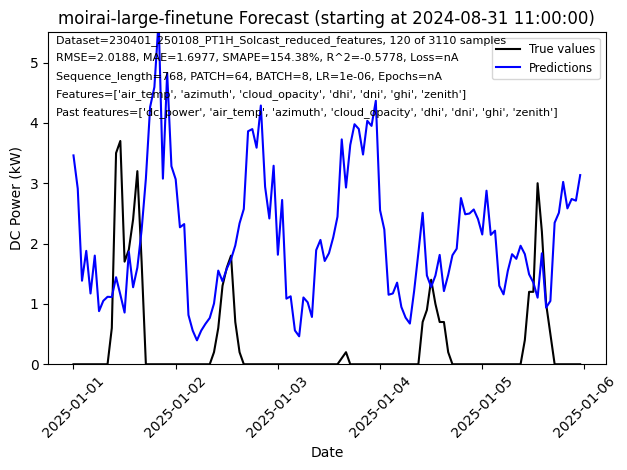

In [103]:
# Step 9: Visualize predictions first plot
start_date = "2025-01-01"
nb_samples = 120 # 10 days if PT1H frequency

# Plot filtered data
plt.plot(df[start_date:]["dc_power"].iloc[:nb_samples], color="black", label="True values")
plt.plot(df[start_date:].iloc[:nb_samples].index, predictions[len(predictions)-len(df[start_date:].iloc[:nb_samples]):], color="blue", label="Predictions")
plt.legend(loc="upper right", fontsize="small")
plt.ylabel("DC Power (kW)")
plt.xlabel("Date")
plt.title(f"{MODEL}-{SIZE}-finetune Forecast (starting at {TEST_DATA_START_DATETIME})")
plt.figtext(0.095, 0.9,f"Dataset={file_name_no_extension(FILEPATH)}, {nb_samples} of {TESTDATA_LENGTH} samples", fontsize=8, color='black')
plt.figtext(0.095, 0.8625,f"RMSE={RMSE:.4f}, MAE={MAE:.4f}, SMAPE={SMAPE:.2f}%, R^2={R2:.4f}, Loss={LOSS}", fontsize=8, color='black')
plt.figtext(0.095, 0.8250,f"Sequence_length={SEQUENCE_LENGTH}, PATCH={PATCH_SIZE}, BATCH={BATCH_SIZE}, LR={LR}, Epochs={NUM_EPOCHS}", fontsize=8, color='black')
plt.figtext(0.095, 0.7875,f"Features={dataset.feat_dynamic_real}", fontsize=8, color='black')
plt.figtext(0.095, 0.7500,f"Past features={dataset.past_feat_dynamic_real}", fontsize=8, color='black')

# Set y-axis limits
plt.ylim(0, 5.5)

# Set y-axis limits and x-axis formatting
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)

# Adjust layout and save plot
plt.tight_layout()
plt.savefig(f"{MODEL}-{SIZE}-finetune-{start_date}-RMSE={RMSE:.4f}-SEQUENCE_L={SEQUENCE_LENGTH}.pdf")
plt.show()

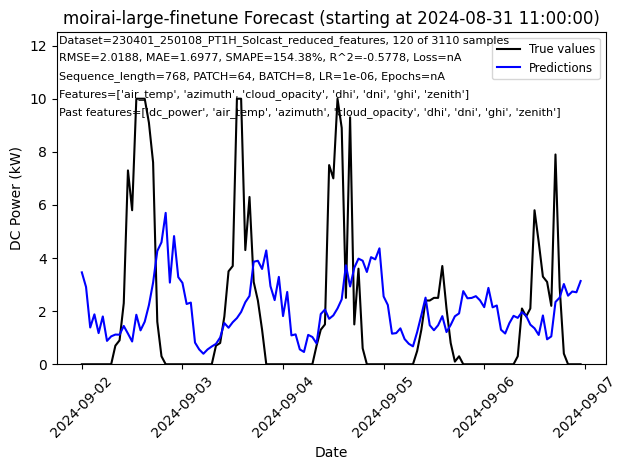

In [104]:
# Step 10: Visualize predictions second plot
start_date = "2024-09-02"
nb_samples = 120 # 10 days if PT1H frequency

# Plot filtered data
plt.plot(df[start_date:]["dc_power"].iloc[:nb_samples], color="black", label="True values")
plt.plot(df[start_date:].iloc[:nb_samples].index, predictions[len(predictions)-len(df[start_date:].iloc[:nb_samples]):], color="blue", label="Predictions")
plt.legend(loc="upper right", fontsize="small")
plt.ylabel("DC Power (kW)")
plt.xlabel("Date")
plt.title(f"{MODEL}-{SIZE}-finetune Forecast (starting at {TEST_DATA_START_DATETIME})")
plt.figtext(0.1, 0.9,f"Dataset={file_name_no_extension(FILEPATH)}, {nb_samples} of {TESTDATA_LENGTH} samples", fontsize=8, color='black')
plt.figtext(0.1, 0.8625,f"RMSE={RMSE:.4f}, MAE={MAE:.4f}, SMAPE={SMAPE:.2f}%, R^2={R2:.4f}, Loss={LOSS}", fontsize=8, color='black')
plt.figtext(0.1, 0.8250,f"Sequence_length={SEQUENCE_LENGTH}, PATCH={PATCH_SIZE}, BATCH={BATCH_SIZE}, LR={LR}, Epochs={NUM_EPOCHS}", fontsize=8, color='black')
plt.figtext(0.1, 0.7875,f"Features={dataset.feat_dynamic_real}", fontsize=8, color='black')
plt.figtext(0.1, 0.7500,f"Past features={dataset.past_feat_dynamic_real}", fontsize=8, color='black')

# Set y-axis limits
plt.ylim(0, 12.5)

# Set y-axis limits and x-axis formatting
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)

# Adjust layout and save plot
plt.tight_layout()
plt.savefig(f"{MODEL}-{SIZE}-finetune-{start_date}-RMSE={RMSE:.4f}-SEQUENCE_L={SEQUENCE_LENGTH}.pdf")
plt.show()

In [ ]:
!pwd

/content


In [18]:
# Fine-tuning in regards to https://github.com/SalesforceAIResearch/uni2ts/blob/main/README.md#fine-tuning
# Step 1 Set Data Path Directory
!echo "CUSTOM_DATA_PATH=/content/uni2ts/" >> .env

In [19]:
!echo "PYTHONPATH=/content/uni2ts" >> .env

In [13]:
!cat .env

CUSTOM_DATA_PATH=/content/uni2ts/
PYTHONPATH=/content/uni2ts


In [20]:
# Step 2.1 process dataset
!python -m uni2ts.data.builder.simple customdataset /content/uni2ts/230401_250108_PT1H_Solcast_reduced_features.csv --dataset_type wide_multivariate

Inferred frequency: H. Using this value for the 'freq' parameter.
Generating train split: 1 examples [00:00,  4.56 examples/s]
Saving the dataset (1/1 shards): 100% 1/1 [00:00<00:00, 254.39 examples/s]


In [21]:
# Step 2.2 Set offset
!python -m uni2ts.data.builder.simple customdataset /content/uni2ts/230401_250108_PT1H_Solcast_reduced_features.csv --date_offset '2024-08-31 10:00:00'

                     dc_power  air_temp  azimuth  cloud_opacity  dhi  dni  ghi  zenith
date                                                                                  
2023-04-01 01:00:00       0.0         8      -27           37.4    0    0    0     125
2023-04-01 02:00:00       0.0         8      -43           46.6    0    0    0     120
2023-04-01 03:00:00       0.0         8      -57           40.6    0    0    0     112
2023-04-01 04:00:00       0.0         7      -70           47.6    0    0    0     103
2023-04-01 05:00:00       0.0         7      -81           58.2    0    0    0      93
...                       ...       ...      ...            ...  ...  ...  ...     ...
2024-08-31 06:00:00       0.0        19      -90           23.9   94   47  104      78
2024-08-31 07:00:00       0.1        21     -101            0.0   89  575  303      68
2024-08-31 08:00:00       0.7        22     -114            0.0  108  683  466      58
2024-08-31 09:00:00       1.3        24    

In [ ]:
#!mv content/uni2ts/cli content/uni2ts/src/uni2ts/

/content


In [ ]:
# Step 3 (move cli dir to src/uni2ts first!!!!)
# Set Batch size here /content/uni2ts/src/uni2ts/cli/conf/finetune/default.yaml to lower value
# For moirai large with A100 40GB RAM use 16 as batch size in val_dataloader and train_dataloader section

!python -m uni2ts.cli.train -cp conf/finetune run_name=example_run model=moirai_1.1_R_large data=etth1 val_data=etth1

In [59]:
# Use Hydra's Sweeping Feature for Hyperparameter Search
!python -m uni2ts.cli.train --multirun -cp conf/finetune run_name=example_run model=moirai_1.1_R_large data=customdataset val_data=customdataset \
  trainer.max_epochs=15 \
  model.lr=1e-5,1e-6 \
  train_dataloader.batch_size=8 \
  val_dataloader.batch_size=8

[2025-02-06 10:39:59,431][HYDRA] Launching 2 jobs locally
[2025-02-06 10:39:59,432][HYDRA] 	#0 : run_name=example_run model=moirai_1.1_R_large data=customdataset val_data=customdataset trainer.max_epochs=15 model.lr=1e-05 train_dataloader.batch_size=8 val_dataloader.batch_size=8
config.json: 100% 684/684 [00:00<00:00, 4.87MB/s]
model.safetensors: 100% 1.24G/1.24G [00:52<00:00, 23.8MB/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[2025-02-06 10:40:56,539][datasets][INFO] - PyTorch version 2.4.1 available.
[2025-02-06 10:40:56,540][datasets][INFO] - TensorFlow version 2.18.0 available.
[2025-02-06 10:40:56,540][datasets][INFO] - JAX version 0.4.33 available.
Seed set to 0
2025-02-06 10:40:57.101290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738838457.123592   14334 

In [ ]:
# Show Tensorboard with results
%load_ext tensorboard
%tensorboard --logdir /content/multirun


In [ ]:
#Export outputs
!zip -r outputs.zip /content/outputs

In [ ]:
# Evaluation
!python -m uni2ts.cli.eval run_name=example_eval_1 model=moirai_1.0_R_small model.patch_size=32 model.context_length=1000 data=etth1_val

In [ ]:
import gc

# Invoke garbage collector
gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()